<b>Сравнение двух подходов к построению рекомендаций</b>

- <b>Коллаборативный</b> (использование только рейтингов)
- <b>Коллаборативный + контентный</b> (использование рейтингов и дополнительной информации о фильмах)

<b>Подключение необходимых библиотек</b>

In [1]:
import pandas as pd
import numpy as np
import scipy
import implicit
from sklearn.metrics import dcg_score, precision_score
from sklearn.model_selection import train_test_split
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k, auc_score

C:\ProgramData\Anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


<b>Загрузка данных из CSV файлов</b><br>
Создание dataframe

In [2]:
movie = pd.read_csv('data/movie.csv')
rating = pd.read_csv('data/rating.csv')
user_movie = movie.merge(rating, how="left", on="movieId")
user_movie.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,4.0,1999-12-11 13:36:47
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6.0,5.0,1997-03-13 17:50:52
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.0,4.0,1996-06-05 13:37:51
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10.0,4.0,1999-11-25 02:44:47
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.0,4.5,2009-01-02 01:13:41


<b>EDA</b>

In [3]:
user_movie.shape

(20000797, 6)

Очистка данных от нулевых значений рейтингов

In [4]:
user_movie.isnull().sum()

movieId        0
title          0
genres         0
userId       534
rating       534
timestamp    534
dtype: int64

In [5]:
user_movie = user_movie.dropna()

In [6]:
user_movie.isnull().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

In [7]:
user_movie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000263 entries, 0 to 20000796
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   title      object 
 2   genres     object 
 3   userId     float64
 4   rating     float64
 5   timestamp  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 1.0+ GB


In [8]:
data = user_movie.iloc[:1000000,:]

p = data.pivot_table(index = ["userId"],columns = ["title"],values = "rating")
p.head(10)

title,Ace Ventura: When Nature Calls (1995),Across the Sea of Time (1995),"Amazing Panda Adventure, The (1995)","American President, The (1995)",Angela (1995),Angels and Insects (1995),Anne Frank Remembered (1995),Antonia's Line (Antonia) (1995),Assassins (1995),Babe (1995),...,Unforgettable (1996),Up Close and Personal (1996),"Usual Suspects, The (1995)",Vampire in Brooklyn (1995),Waiting to Exhale (1995),When Night Is Falling (1995),"White Balloon, The (Badkonake sefid) (1995)",White Squall (1996),Wings of Courage (1995),"Young Poisoner's Handbook, The (1995)"
userId,,,,,,,,,,,,,,,,,,,,,
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Статистические показатели для столбца ```rating``` :<br>
- 20000260 оценок было выставлено пользователями
- Средний рейтинг фильмов по всему датасету ≈ 3.526
- Стандартное отклонение рейтинга ≈ 1.052
- 75% фильмов имеют оценку ≤ 4

In [9]:
user_movie['rating'].describe()

count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

Распределение оценок 

In [10]:
rating_plot = user_movie['rating'].value_counts()
print(user_movie['rating'].value_counts())

4.0    5561926
3.0    4291193
5.0    2898660
3.5    2200156
4.5    1534824
2.0    1430997
2.5     883398
1.0     680732
1.5     279252
0.5     239125
Name: rating, dtype: int64


На графике видно, что самые популярные оценки — 3 и 4

<AxesSubplot:>

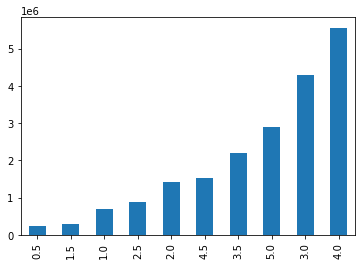

In [11]:
user_movie['rating'].value_counts().sort_values().plot(kind = 'bar')

<b>Подготовка таблицы для использования первого подхода</b>
Здесь необходимо учитывать рейтинг

Разбиение датасета на обучающую и тестовую выборки в соотношении 70/30

In [12]:
x_train, x_test, y_train, y_test = train_test_split(user_movie, user_movie['rating'], train_size=0.7, random_state=0)

In [13]:
print(x_train.shape)
print(x_test.shape)

(14000184, 6)
(6000079, 6)


In [14]:
print(y_train.shape)
print(y_test.shape)

(14000184,)
(6000079,)


<b>Alternating Least Squares</b><br>
Для коллаборативного подхода выбран алгоритм ALS, который раскладывает матрицу предпочтений на произведение матрицы факторов пользователей и матрицы факторов фильмов. <br>
Принцип работы алгоритма состоит в минимизации среднеквадратичной ошибки на проставленных рейтингах.

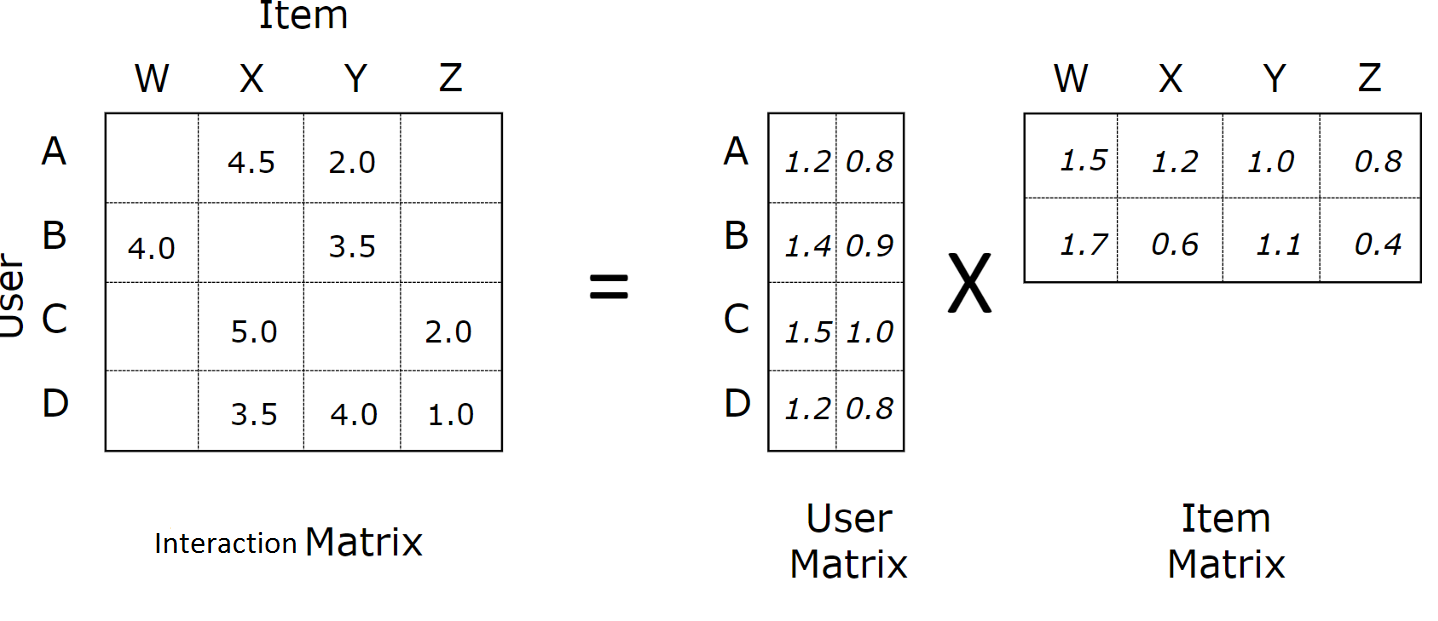

In [15]:
sparse_item_user = scipy.sparse.csr_matrix((y_train, (x_train['movieId'].astype(int), x_train['userId'].astype(int))))

sparse_user_item = scipy.sparse.csr_matrix((y_train, (x_train['userId'].astype(int), x_train['movieId'].astype(int))))

sparse_item_user_test = scipy.sparse.csr_matrix((y_test, (x_test['movieId'].astype(int), x_test['userId'].astype(int))))

sparse_user_item_test = scipy.sparse.csr_matrix((y_test, (x_test['userId'].astype(int), x_test['movieId'].astype(int))))

In [16]:
#Building the model
modelALS = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)
alpha_val = 40
data_conf = (sparse_item_user * alpha_val).astype('double')
modelALS.fit(data_conf)

C:\ProgramData\Anaconda3\lib\site-packages\implicit\utils.py:31: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

In [17]:
def recommendation(data, user_ids, n):
    for user_id in user_ids:
        recommended = modelALS.recommend(user_id, data[user_id], n)
        
        print(f'USER {user_id}')
        print(f'Known posituves: ')    
        known_positives = data[user_id].indices[:n]
        mask = user_movie['movieId'].isin(known_positives)
        for i in user_movie['title'][mask].unique():
            print('          ',i)

        print('GENRES: ')
        for i in user_movie['genres'][mask].unique():
            print('          ',i)
        
        print(f'For USER {user_id} recommended: ')
        mask = user_movie['movieId'].isin(recommended[0]) 
        for i in user_movie['title'][mask].unique():
            print('          ',i)

        print('GENRES: ')
        for i in user_movie['genres'][mask].unique():
            print('          ',i)
        print('----------')


In [18]:
recommendation(sparse_user_item_test, [11, 50, 451], 3)

USER 11
Known posituves: 
           Bad Boys (1995)
           Batman Forever (1995)
           Congo (1995)
GENRES: 
           Action|Comedy|Crime|Drama|Thriller
           Action|Adventure|Comedy|Crime
           Action|Adventure|Mystery|Sci-Fi
For USER 11 recommended: 
GENRES: 
----------
USER 50
Known posituves: 
           Clueless (1995)
           Apollo 13 (1995)
           Before Sunrise (1995)
GENRES: 
           Comedy|Romance
           Adventure|Drama|IMAX
           Drama|Romance
For USER 50 recommended: 
           Absolon (2003)
           Bomb the System (2002)
GENRES: 
           Action|Sci-Fi|Thriller
           Action|Drama
----------
USER 451
Known posituves: 
           Four Rooms (1995)
           Amateur (1994)
           Canadian Bacon (1995)
GENRES: 
           Comedy
           Crime|Drama|Thriller
           Comedy|War
For USER 451 recommended: 
           Vice Squad (1953)
GENRES: 
           Crime|Drama
----------


<b>LightFM</b><br>
Для контентно-коллаборативного подхода выбрана модель LightFM с функией потерь WARP. 

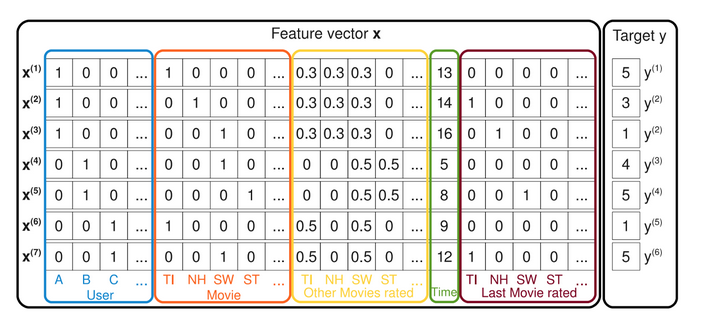

In [19]:
modelLFM = LightFM(loss='warp')
modelLFM.fit(sparse_user_item, epochs=10)

In [20]:
def sample_recommendation(model, data, user_ids, n):
    n_users, n_items = data.shape
    for user_id in user_ids:
        
        print(f'USER {user_id}')
        print(f'Known posituves: ')    
        known_positives = data[user_id].indices[:n]
        mask = user_movie['movieId'].isin(known_positives)
        for i in user_movie['title'][mask].unique():
            print('          ',i)

        print('GENRES: ')
        for i in user_movie['genres'][mask].unique():
            print('          ',i)
        
        scores = model.predict(user_id, np.arange(n_items))

        top_items = data[np.argsort(-scores)]
        top_items = top_items.indices[:n]
        
        print(f'For USER {user_id} recommended:')
        mask = user_movie['movieId'].isin(top_items)
        for i in user_movie['title'][mask].unique():
            print('          ',i)
        print('----------')

    
    

In [21]:
sample_recommendation(modelLFM, sparse_user_item_test, [11, 50, 451], 3)

USER 11
Known posituves: 
           Bad Boys (1995)
           Batman Forever (1995)
           Congo (1995)
GENRES: 
           Action|Comedy|Crime|Drama|Thriller
           Action|Adventure|Comedy|Crime
           Action|Adventure|Mystery|Sci-Fi
For USER 11 recommended:
           Copycat (1995)
           Star Trek: Generations (1994)
           Lion King, The (1994)
----------
USER 50
Known posituves: 
           Clueless (1995)
           Apollo 13 (1995)
           Before Sunrise (1995)
GENRES: 
           Comedy|Romance
           Adventure|Drama|IMAX
           Drama|Romance
For USER 50 recommended:
           Jumanji (1995)
           Batman Forever (1995)
           Congo (1995)
----------
USER 451
Known posituves: 
           Four Rooms (1995)
           Amateur (1994)
           Canadian Bacon (1995)
GENRES: 
           Comedy
           Crime|Drama|Thriller
           Comedy|War
For USER 451 recommended:
           Copycat (1995)
           Star Trek: Generations (1994)
 

Во время выполнения тестового задания получилось проанализировать данные и подготовить их для работы с моделями. 